https://docs.ultralytics.com/ru/tasks/pose/ - информация по YOLO-pose

https://docs.ultralytics.com/ru/modes/track/#tracking - трекинг

# Установка необходимых библиотек

In [1]:
!pip install lapx # Требуется для работы трекера и может требовать перезапуска среды

In [2]:
!pip install ultralytics

  Using cached ultralytics-8.2.77-py3-none-any.whl.metadata (41 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached scipy-1.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.19.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.0 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached py_cpui

In [7]:
# @title Импорт необходимых библиотек
import cv2
import requests
import os
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from ultralytics import YOLO
import time

# Часть 1 "Обработка видео"
В этой части извлекаются данные о ключевых точках поз людей на видео. Для этого создается функция extract_predictions, которая использует предобученную модель YOLO8x-pose. Модель YOLO8n-pose оказалась слишком слабой, многие люди на видео, даже на небольшом удалении не были распознаны.
Собранные видео помещаются в папку. В разделе "Запуск функции в папке" запускается код, в котором указаны пути к папке с подготовленными видео и к папке, в которую будет сохраняться результат. Каждое видео в папке подается на вход в функцию extract_predictions.
Результатом ее работы является распознанное видео, на котором все люди находятся внутри Bounding boxes и все кадры видео пронумерованы, а также данные в табличном виде, сохраненные в формате pickle. То есть на каждое подготовленное видео на выходе будет два файла (распознанное видео и таблица с данными). Координатам ключевых точек, которые не были распознаны на кадре, присваивается значение "-1".


In [4]:
# @title Вспомогательные функции

# Контекстный менеджер для измерения времени операций
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        # Расчет времени выполнения
        result_time = time.time()-self.t
        hour = int(result_time//3600)
        min = int(result_time//60)-hour*60
        sec = int(round(result_time%60))
        msec = round(1000*result_time%60)

        if hour > 0:
          print('Время обработки: ' + str(hour)+' час. ' + str(min)+' мин.')
        elif min > 0:
          print('Время обработки: ' + str(min)+' мин. ' + str(sec)+' сек.')
        elif sec > 0:
          print('Время обработки: ' + str(sec)+' сек.')
        else:
          print('Время обработки: ' + str(msec)+' мс.')

 Функция обработки видео

In [9]:
def extract_predictions(Path, Out_path = None, model_name = 'yolov8x-pose.pt'):

  _, FileName = os.path.split(Path)
  _, Ext = os.path.splitext(FileName)

  # Создаем путь для сохранения файлов
  if not Out_path:
    Out_path = Path[:-len(Ext)]
  else:
    Out_path = os.path.join(Out_path, FileName[:-len(Ext)])

  # Инициализация модели
  model = YOLO(model_name)

  # Переменные для шрифта номера кадра
  font = cv2.FONT_HERSHEY_COMPLEX
  font_size = 1.4
  h_space = int(20*font_size)
  v_space = int(30*font_size)
  frame_num_color = (0,255,255)

  # Указание длины трека
  track_lenght = 30

  # Цвет линии трека
  track_color = (255,255,0)

  # Толщина линии трека
  track_thickness = 5

  # Создать объект захвата видео
  video_in = cv2.VideoCapture(Path)


  # Если видео не удалось открыть
  if (video_in.isOpened() == False):
    # Сообщение об ошибке
    print('Не удалось считать кадр из видео!')
    # Освобождаем объект захвата видео
    video_in.release()
    cv2.destroyAllWindows()

  else:
    # Количество кадров в секунду (примерная оценка)
    fps = int(video_in.get(cv2.CAP_PROP_FPS))

    # Всего кадров (примерная оценка)
    frames = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))

    # Разрешение видео
    width = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Вывод информации о файле
    print('В видеофайле c частотой кадров: '+str(fps)+' кадр(а,ов)/сек\nразрешением: '+ str(width)+'x'+str(height)+'\nсодержится (но это не точно): '+ str(frames)+' кадр(а,ов).')

    # Создаем объект записи видео для вывода результатов
    video_out = cv2.VideoWriter(Out_path+'_out.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    # Создаем датафрейм pandas для сохранения данных
    Data_df = pd.DataFrame(columns=['Frame', 'Id', 'Coords', 'Keypoints', 'Normalized_KP', 'Conf','KP_Conf'])

    # Создаем словарь для хранения треков
    track_history = defaultdict(lambda: [])

    # Инициализируем счетчик кадров
    frame_num = 0

    # Прыгаем к нужному кадру
    if not frame_num == 0:
      if 0 < frame_num < frames:
        video_in.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
      else:
        print('Стартовый кадр задан не корректно и будет сброшен на 0!')
        frame_num = 0

    # Инициализация шкалы загрузки
    max_length = 100
    percent = 0

    # Количество кадров попадающих в один процентный промежуток
    frame_step = (frames-frame_num)//max_length+1
    if frame_step > 1:
      bar_step = 1
    else:
      bar_step = max_length/(frames-frame_num)

    # Пустая шкала прогресса
    print('['+' '*max_length+']', end = '')


    # Считываем кадр
    is_read, frame = video_in.read()

    while is_read:

      # Обрабатываем кадр
      results = model.track(frame, persist=True, verbose=False)

      try:

        # Извлекаем BBoxы и ID треков
        boxes_xywh = results[0].boxes.xywh.cpu().tolist()
        boxes_xyxy = results[0].boxes.xyxy.cpu().tolist()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        confs = results[0].boxes.conf.cpu().tolist()

        # Извлекаем относительные положени ключевых точек и уверенность сети в их определении
        all_keypoints = results[0].keypoints.xy.cpu().tolist()
        all_kp_confs = results[0].keypoints.conf.cpu().tolist()


        # Визуализируем результаты на кадре
        annotated_frame = results[0].plot()

        # Добавляем номер кадра
        cv2.putText(annotated_frame, str(frame_num), (width-(2+len(str(frame_num)))*h_space,2*v_space), font, font_size, color=frame_num_color, thickness=2)

        # Отображение трека
        for box_xywh, box_xyxy, track_id, conf, keypoints, kp_confs in zip(boxes_xywh, boxes_xyxy, track_ids, confs, all_keypoints, all_kp_confs):

            # Определяем координаты рамки
            x, y, w, h = box_xywh
            x_min, y_min, x_max, y_max = box_xyxy

            # Вычисляем нормированные значения keypoints
            delta = [x_min, y_min]
            scaler = [x_max - x_min, y_max - y_min]

            # Вариант сохранения отрицательных normalized_KP для нулевых значений keypoints
            #normalized_KP = ((np.asarray(keypoints)-np.asarray(delta))/np.asarray(scaler)).tolist()
            normalized_KP = []
            # Вариант сохранения нулевых normalized_KP для нулевых значений keypoints
            for coord in keypoints:
                if coord == [0.0, 0.0]:
                    normalized_KP.append([-1.0, -1.0])
                else:
                    normalized_coord = ((np.asarray(coord) - np.asarray(delta)) / np.asarray(scaler)).tolist()
                    normalized_KP.append(normalized_coord)
            #print(box, track_id, conf, keypoints, kp_confs, normalized_KP)

            # Добавляем данные в датафрейм
            Data_df.loc[len(Data_df.index)] = [frame_num, track_id, box_xyxy, keypoints, normalized_KP, conf, kp_confs]

            # Выбираем нужный трек
            track = track_history[track_id]
            track.append((float(x), float(y)))  # Добавление в трек центральной точки
            if len(track) > track_lenght:       # Обрезание до заданной длины трека
                track.pop(0)

            # Нанесение линии трека
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [points], isClosed=False, color=track_color, thickness=track_thickness)

        # Сохраняем обработанный кадр в видео
        video_out.write(annotated_frame)

      except:
        # Сохраняем обработанный кадр в видео
        video_out.write(frame)

      # Кадр сохраняется в заданную папку (к имени видео добавляется номер кадра)
      #сv2.imwrite(os.path.join(Out_Path, name + Separator + num_text + '.' + Extension), annotated_frame)

      # Считываем следующий кадр
      is_read, frame = video_in.read()

      # Увеличиваем счетчик кадров
      frame_num += 1

      # Если количество обработаных кадров достигло очередной ступени шкалы, заполняется деление шкалы
      if frame_num > frame_step*percent:
        percent += 1
        print('\b'*(max_length+1)+'='*int(percent*bar_step) + ' '*(max_length-int(percent*bar_step))+']', end = '')

    # Освобождаем объекты видео
    video_in.release()
    video_out.release()
    cv2.destroyAllWindows()

    # Сохранияем датафрейм Pandas в формате pickle, чтобы после загрузки сохралились списки
    Data_df.to_pickle(Out_path+'_out.pickle')

    # Рисуем полную шкалу
    print('\b'*(max_length+2-percent)+'='*(max_length-percent+1)+']', end = '')

    return [FileName, Out_path+'_out.avi', Out_path+'_out.pickle']

 Запуск функции в папке

In [14]:
with timex():
  # Путь к каталогу с видео для обработки
  source = '/home/server/projects/diplom/Data/source/add'

  # Путь для сохранения результатов обработки
  destination = '/home/server/projects/diplom/Data/result/no_fights_data'

  # Список расширений файлов (на случай если в папке еще что-то есть)
  ext_list = ['.mp4','.avi','.mov']

  # Список для хранения имен файлов
  Files_List = []

  # Список для хранения имен файлов
  Out_Video_List = []

  # Список для хранения имен файлов
  Out_Pandas_List = []

  # Создание каталога для сохранения при его отсутствии
  if not os.path.exists(destination):
    os.mkdir(destination)


  if os.path.isfile(destination):
    print('Существует файл идентичный имени каталога!\nУдалите/переименуйте файл или измените путь для сохранения.')
  else:
    # Запуск обработки
    for file_name in os.listdir(source):
      _, ext = os.path.splitext(file_name)
      if ext in ext_list:
        with timex():
          print(f'\nНачало обработки файла {file_name}.')
          FileName, Out_Video, Out_Pandas = extract_predictions(os.path.join(source,file_name), destination, 'yolov8x-pose.pt')
          Files_List.append(FileName)
          Out_Video_List.append(Out_Video)
          Out_Pandas_List.append(Out_Pandas)
          print(f'\nФайл обработан.\nВидео сохранено в: {Out_Video}\nДанные сохранены в: {Out_Pandas}')

    print(f'\nОбработка закончена. Всего обработано {len(Files_List)} файл(а,ов).')


Начало обработки файла sit_1.mp4.
В видеофайле c частотой кадров: 25 кадр(а,ов)/сек
разрешением: 1920x1080
содержится (но это не точно): 69 кадр(а,ов).
[                                                                                                    =                                                                                                   ==                                                                                                  ====                                                                                                =====                                                                                               =======                                                                                             ========                                                                                            ==========                                                                                          ===========                                   

#Часть 2. "Исследование полученных данных"
В этой части идет анализ полученных данных, просматриваются полученные табличные данные, анализируется количество уникальных id на конкретных видео, оценивается качество распознавания ключевых точек на конкретных кадрах, выявляются моменты, которые нужно будет отфильтровать (например, зрители в зале, которые не имеют точек ниже пояса). Так же было выявлено, что YOLO-pose дает предсказание на точки, которые не видит. То есть у зрителей в зале, у которых не видно нижних точек туловища эти точки все же были распознаны YOLO-pose. В результате ключевые точки часто выходят за рамку Bounding boxe (показано в разделе "Вывод полного кадра" id_12 и id_9). Как следствие, нормированные значения координат ключевых точек часто выходят за единицу (продемонстрированно в разделе "Проверка нормированных данных на выход за рамку").

In [ ]:
# @title Загрузка файлов, полученных после обработки

import os

# Путь к папке с файлами
folder_path = "/content/drive/MyDrive/test/result/"

# Создание списка для хранения имен файлов
Out_Pandas_List = []
Files_List = []
# Проход по всем файлам в папке
for file_name in os.listdir(folder_path):
    # Проверка, что файл имеет расширение .pickle
    if file_name.endswith("out.pickle"):
        # Добавление имени файла в список
        Out_Pandas_List.append(folder_path+file_name)
    elif file_name.endswith(".avi"):
        # Добавление имени файла в список
        Files_List.append(folder_path+file_name)
count_files = len(Out_Pandas_List)
print(f'Получен список из {count_files} видеофайл(а,ов)')

Получен список из 0 видеофайл(а,ов)


In [ ]:
# Выбор видео
video_num = 0

# Отображение пути к данным, полученным из этого видео
print(Files_List[video_num])

/content/drive/MyDrive/safe_city_full/version_1/no_fights_data/bicyclist_3_out.avi


In [ ]:
# Загрузка данных в  DataFrame
Data_df = pd.read_pickle(Out_Pandas_List[video_num])

In [ ]:
# Список уникальных Id
Data_df['Id'].unique().tolist()

[1, 2, 3, 4, 5, 7, 10, 12, 13, 14, 15, 16]

In [ ]:
# Отображение табличных данных
display(Data_df['Coords'])

0                           [207.0, 578.0, 385.0, 742.0]
1                         [1592.0, 592.0, 1740.0, 851.0]
2                        [1035.0, 379.0, 1471.0, 1004.0]
3                             [0.0, 677.0, 180.0, 843.0]
4                           [615.0, 586.0, 733.0, 844.0]
                             ...                        
343    [137.67837524414062, 527.7374267578125, 308.36...
344    [1247.110595703125, 487.0090026855469, 1440.74...
345    [261.6548767089844, 537.0231323242188, 440.233...
346    [918.06298828125, 483.3624267578125, 1161.1628...
348    [1792.925537109375, 293.2292785644531, 1917.66...
Name: Coords, Length: 264, dtype: object

In [ ]:
# Список уникальных Id
Data_df['Id'].unique().tolist()

In [ ]:
# Список последних 10 уникальных кадров
Data_df['Frame'].unique().tolist()[-10:]

[85, 86, 87, 88, 89, 90, 91, 92, 93, 94]

In [ ]:
# Выбираем 10-й в списке кадров (можно и просто 10, но так безопаснее если какие-то кадры будут удалены)
frame_num = Data_df['Frame'].unique().tolist()[10]
print(f'Кадр: {frame_num}')
# Выбираем первый доступный Id на кадре
id = Data_df[Data_df['Frame'] == frame_num]['Id'].unique().tolist()[0]
print(f'Id: {id}')

Кадр: 10
Id: 1


In [ ]:
# Извлекаем соответствующий бокс
box = Data_df[(Data_df['Frame'] == frame_num)&(Data_df['Id']==id)].iloc[0]['Coords']

In [ ]:
# Создать объект захвата видео
video_in = cv2.VideoCapture(Files_List[video_num])
frame_num = 110
# Если видео не удалось открыть
if (video_in.isOpened() == False):
  # Сообщение об ошибке
  print('Не удалось считать кадр из видео!')
else:
  video_in.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
  # Считываем следующий кадр
  is_read, frame = video_in.read()
  if is_read:
    cropped_frame = frame[500:, 100:1600]
    cv2_imshow(cropped_frame)

# Освобождаем объект захвата видео
video_in.release()
cv2.destroyAllWindows()

Вывод полного кадра

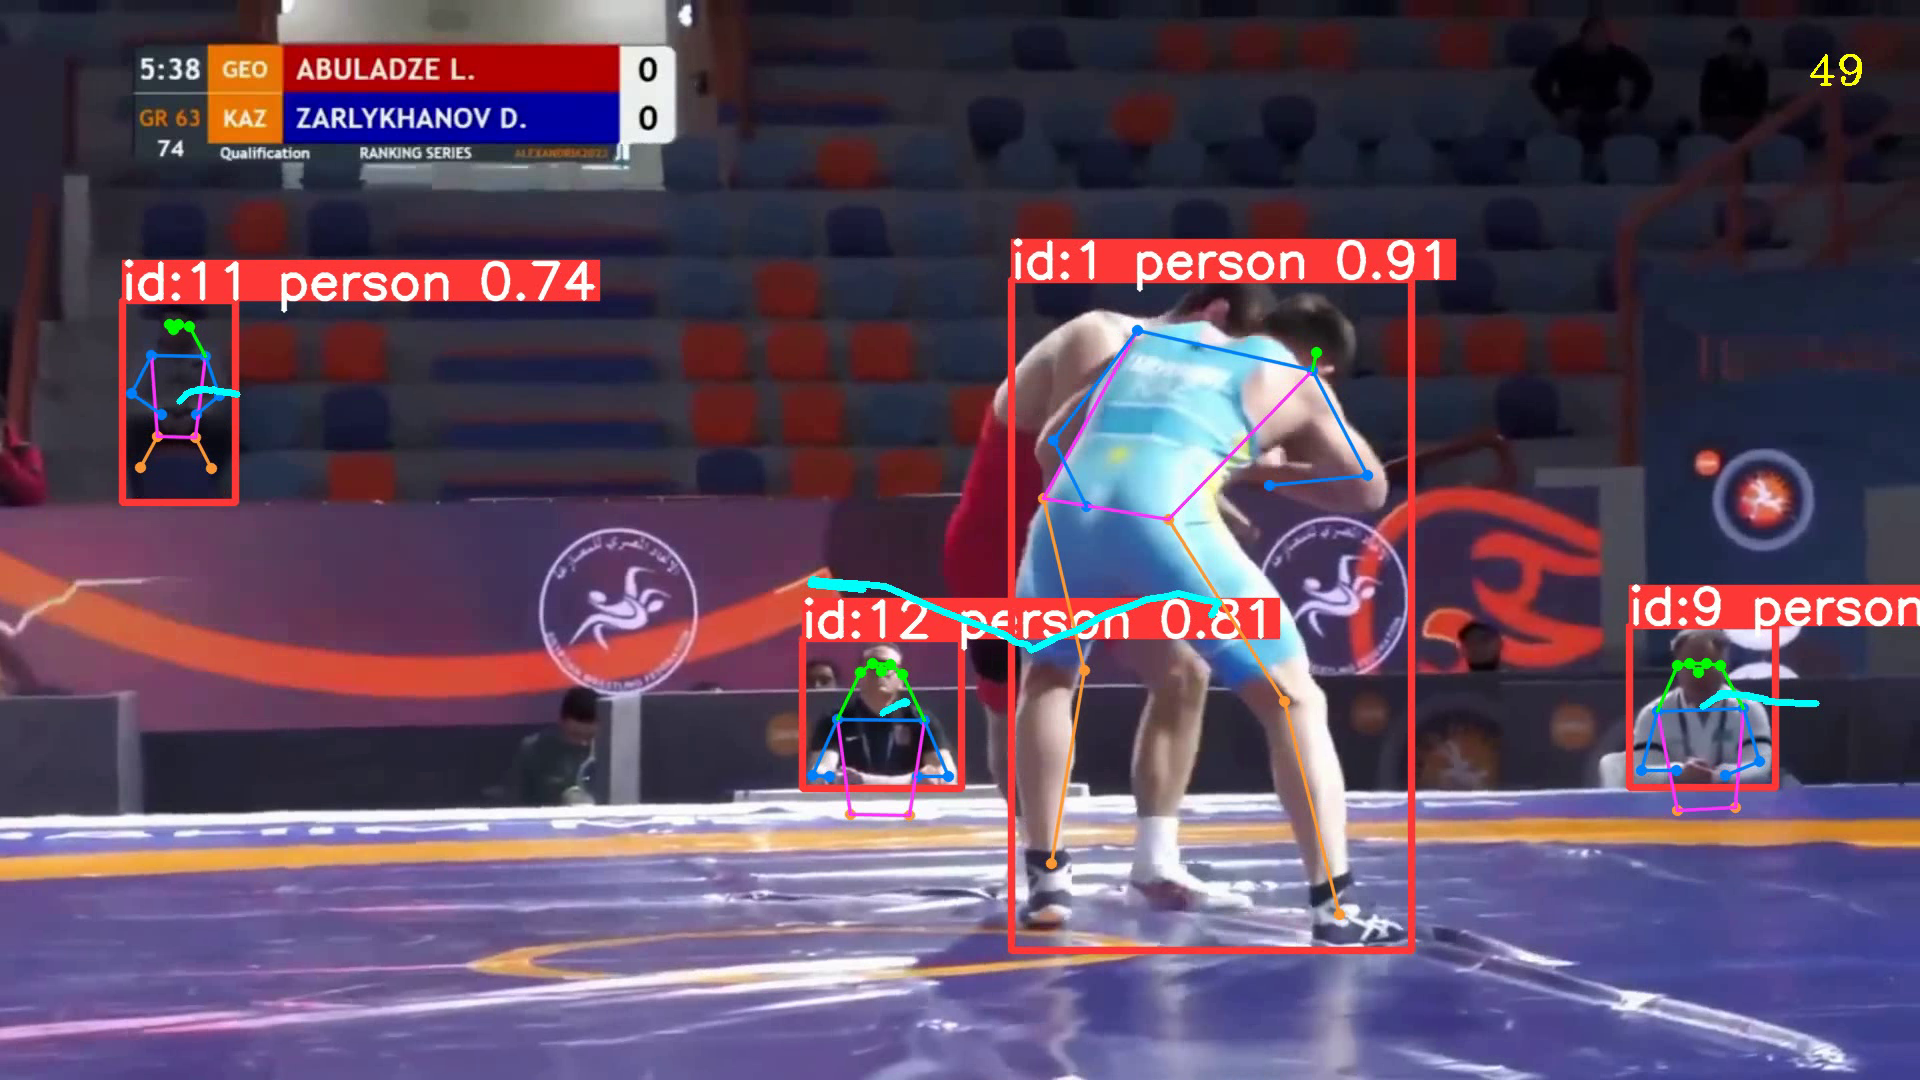

In [ ]:
# Создать объект захвата видео
video_in = cv2.VideoCapture(Files_List[video_num])

# Если видео не удалось открыть
if (video_in.isOpened() == False):
  # Сообщение об ошибке
  print('Не удалось считать кадр из видео!')
else:
  video_in.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
  # Считываем следующий кадр
  is_read, frame = video_in.read()
  if is_read:
    cv2_imshow(frame)

# Освобождаем объект захвата видео
video_in.release()
cv2.destroyAllWindows()

Проверка нормированных данных на выход за рамку

In [ ]:
# ПРОВЕРКА НОРМАИРОВАННЫХ ДАННЫХ Normalized_KP НА НАЛИЧИЕ ЗНАЧЕНИЙ БОЛЬШЕ 1
count_rows = Data_df.shape[0]

for row in range(count_rows):
  # Выбор столбца 'Normalized_KP'
  normalized_kp_list = Data_df.iloc[row, 4]
  # Проверка, есть ли хотя бы одно значение больше 1 в списке normalized_kp_list
  for sublist in normalized_kp_list:
      for value in sublist:
          if value > 1:
              id = Data_df.iloc[row, 1]
              frame = Data_df.iloc[row, 0]
              print(f'В строке {row} Normalized_KP равен {value} для id {id}. Кадр {frame}')

В строке 1 Normalized_KP равен 1.27443359375 для id 2. Кадр 0
В строке 1 Normalized_KP равен 1.28212646484375 для id 2. Кадр 0
В строке 3 Normalized_KP равен 1.2118259006076388 для id 4. Кадр 0
В строке 6 Normalized_KP равен 1.2649946206544085 для id 2. Кадр 1
В строке 6 Normalized_KP равен 1.2617572474678012 для id 2. Кадр 1
В строке 11 Normalized_KP равен 1.268433870249089 для id 2. Кадр 2
В строке 11 Normalized_KP равен 1.2640852391909845 для id 2. Кадр 2
В строке 17 Normalized_KP равен 1.2529507171927052 для id 2. Кадр 3
В строке 17 Normalized_KP равен 1.2513704963909587 для id 2. Кадр 3
В строке 22 Normalized_KP равен 1.2469124425080729 для id 2. Кадр 4
В строке 22 Normalized_KP равен 1.244688552300829 для id 2. Кадр 4
В строке 27 Normalized_KP равен 1.2467344221876346 для id 2. Кадр 5
В строке 27 Normalized_KP равен 1.2428744724232725 для id 2. Кадр 5
В строке 32 Normalized_KP равен 1.2563548343518947 для id 2. Кадр 6
В строке 32 Normalized_KP равен 1.2548643945794125 для id 2. К

# Часть 3. "Фильтрация данных"
Для обучения нейросети необходимо выделить то поведение людей, которые она будет учиться распознавать. При распознавании видео не все id, попавшие в кадр, демонстрируют интересующее нас поведение. Поэтому данные необходимо отфильтровать. Для этого в разделе "Оставляем только те id, которые участвуют в драках" код открывает каждый файл с расширением "pickle" и предлагает пользователю ввести номера id через пробел, которые нужно оставить. Для выбора таких id необходимо параллельно запустить одноименное распознанное видео и визуально определить, какие id демонстрируют интересующее нас поведение. На выходе мы получаем отфильтрованные табличные данные и словарь с выбранными id и названиями видео, к которому они привязаны. Эти данные помещаются в папку «драки», и они уже готовы для подачи на обучение нейросети. Далее, в разделе "Фильтрация данных 2" снова берутся те же файлы с расширением "pickle", еще не отфильтрованные из папки с драками и берется полученный словарь с id после первой фильтрации. Здесь происходит обратная операция, из данных удаляются все данные, относящиеся к дракам, и остаются данные с "обычным" поведением людей. То есть в данных останутся только те id, которые НЕ были выбраны при первой фильтрации. Эти данные так же пригодятся в дата сете для папки "не драки". После фильтрации происходит удаление данных об id, которые были на видео меньше 4 кадров, так как предполагается, что нейросеть будет обучаться на данных об изменении координат ключевых точек человека, взятых из последовательности длиной не менее 4 кадров. Дата сет "не драки" содержит подклассы, такие как "стоящие люди", "идущие спиной", "прыгающие" и т.д. Для балансировки подклассов создаются копии видеозаписей, чтобы кол-во видеозаписей в дата сете каждого подкласса было относительно одинаковым.



In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
# @title Загрузка списка данных, полученных после обработки

# Путь к папке с файлами
folder_path = "Data/result/fights_data/"

# Создание списка для хранения имен файлов
Out_Pandas_List = []
Files_List = []
# Проход по всем файлам в папке
for file_name in os.listdir(folder_path):
    # Проверка, что файл имеет расширение .pickle
    if file_name.endswith("out.pickle"):
        # Добавление имени файла в список
        Out_Pandas_List.append(folder_path+file_name)
    elif file_name.endswith(".avi"):
        # Добавление имени файла в список
        Files_List.append(folder_path+file_name)
Out_Pandas_List = sorted(Out_Pandas_List)
count_files = len(Out_Pandas_List)
print(f'Получен список из {count_files} видеофайл(а,ов)')


Получен список из 100 видеофайл(а,ов)


In [29]:
# @title Загружаем словарь с id для видео с драками, если он уже есть
# Путь к файлу с данными
file_path = "/home/server/projects/diplom/Data/result/data.pickle"

id_data = pd.read_pickle(file_path)

['3', '10']

In [3]:
# @title Оставляем только те id, которые участвуют в драках
import os
import pandas as pd

# Проверяем, существует ли уже словарь user_data
if 'id_data' not in locals():
    id_data = {}  # Создаем новый словарь, если он еще не существует

# Выбор элемента, с которого будет начат цикл
number_files = 0
for file in Out_Pandas_List[number_files:]:
    Data_df = pd.read_pickle(file)
    file_name = os.path.basename(file).split('.')

    # Проверяем, есть ли уже сохраненные ID для данного файла
    if file_name[0] in id_data:
        ids = id_data[file_name[0]]
        print(f"Используются сохраненные ID для видеофайла {file_name[0]}: {ids}")
    else:
        ids = input(f"Введите ID, которые необходимо оставить через пробел для видеофайла {file_name[0]}: ")
        ids = ids.split()
        id_data[file_name[0]] = ids  # Сохраняем введенные ID в словаре

    # Создаем список фильтрованных строк в зависимости от введенных ID
    filters = [Data_df['Id'] == int(id) for id in ids]

    # Объединяем фильтры с помощью логического оператора "или"
    final_filter = pd.concat(filters, axis=1).any(axis=1)

    filtered_rows = Data_df[final_filter]

    import pickle

    # Создаем новое имя файла
    new_file_name = file_name[0] + "_filtered." + file_name[1]

    directory_path = os.path.dirname(file)
    save_path = os.path.join(directory_path, new_file_name)

    # Записываем новый файл
    with open(save_path, 'wb') as f:
        pickle.dump(filtered_rows, f)


In [26]:
# @title Сохраняем полученный словарь
# Путь для сохранения словаря
save_path = "Data/result/data.pickle"

# Сохраняем словарь в файл
with open(save_path, 'wb') as f:
    pickle.dump(id_data, f)

In [30]:
# @title Фильтрация данных 2 (только для видео с драками). Из файла "id_data.pickle", полученнего при фильтрации видео с драками берем id, которые учавствовали в драках и удаляем все данные с ними из исходных файлов. Получаем данные об id, которые не учавствовали в драках и добавляем эти данные в "no_fights_data"

# Откуда берем данные для фильтрации
folder_path = '/home/server/projects/diplom/Data/result/fights_data/'

# Куда сохраняем обработанные файлы
output_folder = '/home/server/projects/diplom/Data/result/no_fights_data/'

# Создание списка для хранения имен файлов
Out_Pandas_List = []

# Проход по всем файлам в папке
for file_name in os.listdir(folder_path):
    # Проверка, что файл имеет расширение out.pickle
    if file_name.endswith("out.pickle"):
        # Добавление имени файла в список
        Out_Pandas_List.append(folder_path+file_name)

# Счетчик обработанных файлов
processed_files_count = 0

# Выбор элемента, с которого будет начат цикл
number_files = 0
for file in Out_Pandas_List[number_files:]:
    Data_df = pd.read_pickle(file)
    file_name = os.path.basename(file).split('.')

    # Загружаем список всех id, участвующих в драке по всем видео в папке "fights_data"
    Data_df_id_remove = pd.read_pickle("/home/server/projects/diplom/Data/result/id_fight.pickle")


    elements_to_remove = list(map(int, Data_df_id_remove[file_name[0]])) # id, которые нужно удалить на выбранном видео
    unique_ids = Data_df['Id'].unique().tolist() # Получаем список всех уникальных id на конкретном видео

    # Удаляем id
    for element in elements_to_remove:
        try:
            unique_ids.remove(element)
        except:
            print(f'Невозможно удалить.{element} отсутсвует в списке')

    filters = [Data_df['Id'] == int(id) for id in unique_ids]
    # Создаем список фильтрованных строк в зависимости от введенных ID. В таком варианте остаются данные id, которые были введены
    # filters = [Data_df['Id'] == int(id) for id in ids]

    # Объединяем фильтры с помощью логического оператора "или"
    final_filter = pd.concat(filters, axis=1).any(axis=1)

    filtered_rows = Data_df[final_filter]

    # Создаем новое имя файла
    new_file_name = file_name[0] + '.' + file_name[1]

    save_path = os.path.join(output_folder, new_file_name)

    # Записываем новый файл
    filtered_rows.to_pickle(save_path)

    # Увеличиваем счетчик обработанных файлов
    processed_files_count += 1

# Выводим количество обработанных файлов
print("Обработано {} файл(а,ов).".format(processed_files_count))


Обработано 100 файл(а,ов).


In [32]:
import os
# @title Удаляем строки с id, встречающимися менее чем на 4 кадрах на видео. На выходе получаем файлы, оканчивающиеся на "_filtered.pickle"
def process_file(file_path):
    df = pd.read_pickle(file_path)
    id_counts = df['Id'].value_counts()
    ids_to_remove = id_counts[id_counts < 4].index
    df = df[~df['Id'].isin(ids_to_remove)]
    return df

# Папка, содержащая ваши файлы
folder_path = 'Data/result/no_fights_data/'

# Папка для сохранения отфильтрованных данных
folder_path_destination= 'Data/result/ok_data/no_fights_data_filtred/'

# Список файлов в папке
list_files = os.listdir(folder_path)

# Счетчик обработанных файлов
processed_files_count = 0

# Проходимся по каждому файлу, обрабатываем его и сохраняем результат
for file_name in list_files:
    if file_name.endswith('out.pickle'):  # Предполагается, что ваши файлы имеют расширение .peackle
        file_path = os.path.join(folder_path, file_name)
        df_processed = process_file(file_path)
        new_file_name = os.path.splitext(file_name)[0] + '_filtered.pickle'
        new_file_path = os.path.join(folder_path_destination, new_file_name)
        df_processed.to_pickle(new_file_path)
        processed_files_count += 1

print("Обработано {} файлов.".format(processed_files_count))


Обработано 219 файлов.


# Часть 4. "Создание генератора"
Логика генератора устроена таким образом, что в каждом цикле генератор обращается к папке с подготовленными данными, берет из нее случайный файл с табличными данными, берет случайный id, из тех, что есть в этом файле, берет случайный начальный кадр из тех, на которых есть выбранный id и, начиная с этого кадра, забирает данные о нормированных координатах ключевых точек человека. Длина последовательности кадров, из который будут взяты данные для обучения так же определяется настрйоками генератора. В каждой итерации код обращается по одному разу к папке "драки" и "не драки". Таким образом, на выходе генератора получается готовый сбаллансированный датасет, который на половину состоит из данных о "драках" и на половину из данных о "не драках".


In [18]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

In [19]:
# @title Функция возвращает синус и косинус угла, между линией, образованной координами двух точек, и вертикалью
import math

def calculate_angle(point1, point2):
    # Проверяем, равна ли любая из координат точек нулю
    if 0 in point1 or 0 in point2:
        return 0, 0

    # Вычисляем вектор AB
    vector_AB = (point2[0] - point1[0], point2[1] - point1[1])

    # Вычисляем скалярное произведение векторов AB и (0, -1)
    dot_product = vector_AB[0] * 0 + vector_AB[1] * -1

    # Вычисляем длину вектора AB
    length_AB = math.sqrt(vector_AB[0]**2 + vector_AB[1]**2)

    # Проверяем, не является ли длина вектора нулем (чтобы избежать деления на ноль)
    if length_AB == 0:
        return 0, 0

    # Вычисляем косинус угла между векторами AB и (0, -1)
    cos_angle = dot_product / length_AB

    # Вычисляем синус угла между векторами AB и CD
    if cos_angle < -1:
      cos_angle = -1
    elif cos_angle > 1:
      cos_angle = 1

    sin_angle = math.sqrt(1 - cos_angle**2)

    # Возвращаем косинус и синус угла
    return cos_angle, sin_angle



In [20]:
import os
import random
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def get_pickle_files(directory):
    return [file for file in os.listdir(directory) if file.endswith('filtered.pickle')]

def group_files_by_class(files):
    file_groups = {}
    for file in files:
        class_name = file.split('_')[0]  # Получаем имя класса из названия файла
        if class_name not in file_groups:
            file_groups[class_name] = []
        file_groups[class_name].append(file)
    return file_groups

def generate_angles_data_v2(fight_dir, no_fight_dir, step, num_samples, skipping):
    # Получаем список всех файлов из соответствующих папок и группируем их по классам
    fight_files = group_files_by_class(get_pickle_files(fight_dir))
    no_fight_files = group_files_by_class(get_pickle_files(no_fight_dir))

    # Создаем пустые списки для нормализованных значений ключевых точек
    data_fight = []
    data_no_fight = []
    angles_data_fight = []
    angles_data_no_fight = []

    # Инициализация счетчиков для циклического перебора классов
    fight_classes = list(fight_files.keys())
    no_fight_classes = list(no_fight_files.keys())
    fight_class_index = 0
    no_fight_class_index = 0
    mma_usage_count = 0

    with tqdm(total=num_samples) as pbar:
        while len(data_fight) + len(data_no_fight) < num_samples:
            try:
                # Выбираем класс "MMA" три раза, остальные — по одному
                if mma_usage_count < 3 and 'MMA' in fight_classes:
                    fight_class = 'MMA'
                    mma_usage_count += 1
                else:
                    fight_class = fight_classes[fight_class_index]
                    fight_class_index = (fight_class_index + 1) % len(fight_classes)
                    if fight_class == 'MMA':
                        mma_usage_count = 0  # Сбрасываем счётчик, чтобы после всех классов снова можно было использовать "MMA"

                no_fight_class = no_fight_classes[no_fight_class_index]
                no_fight_class_index = (no_fight_class_index + 1) % len(no_fight_classes)

                # Если список файлов для выбранного класса стал пустым, то снова загружаем весь список
                if not fight_files[fight_class]:
                    fight_files[fight_class] = group_files_by_class(get_pickle_files(fight_dir))[fight_class]
                if not no_fight_files[no_fight_class]:
                    no_fight_files[no_fight_class] = group_files_by_class(get_pickle_files(no_fight_dir))[no_fight_class]

                # Выбираем по одному случайному файлу из выбранных классов
                random_file_fight = random.choice(fight_files[fight_class])
                random_file_no_fight = random.choice(no_fight_files[no_fight_class])

                # Исключаем выбранные файлы из списка
                fight_files[fight_class].remove(random_file_fight)
                no_fight_files[no_fight_class].remove(random_file_no_fight)

                # Загружаем выбранные файлы в DataFrame
                fight_df = pd.read_pickle(fight_dir + random_file_fight).reset_index()
                no_fight_df = pd.read_pickle(no_fight_dir + random_file_no_fight).reset_index()

                # Случайно выбираем индекс для каждого DataFrame из столбца 'Id'
                fight_id = random.choice(fight_df['Id'].unique().tolist())
                no_fight_id = random.choice(no_fight_df['Id'].unique().tolist())

                # Получаем все индексы строк, в которых id == fight_id и id == no_fight_id, кроме последних строк, в количестве step*skipping
                fight_indices = fight_df[fight_df['Id'] == fight_id].index[:-step*(skipping)].tolist()
                no_fight_indices = no_fight_df[no_fight_df['Id'] == no_fight_id].index[:-step*(skipping)].tolist()

                # Задаем начальные индексы
                index_fight = random.choice(fight_indices)
                index_no_fight = random.choice(no_fight_indices)

                # Выбираем строки через skipping строк и таким образом набираем нужное количество строк step
                data_fight += [fight_df['Keypoints'][index_fight:index_fight + step * skipping:skipping].tolist()]
                data_no_fight += [no_fight_df['Keypoints'][index_no_fight:index_no_fight + step * skipping:skipping].tolist()]

                # Обновление прогресс-бара
                pbar.update(2)

            except Exception as e:
                pass

        # Убеждаемся, что прогресс-бар достиг 100%
        pbar.close()

        def process_data(data_list, angles_data_list):
            for items in data_list:
                angles_summ = []
                for item in items:
                    angles = []
                    # плечо
                    angles += [calculate_angle(item[5], item[7])]
                    angles += [calculate_angle(item[6], item[8])]
                    # предплечье
                    angles += [calculate_angle(item[7], item[9])]
                    angles += [calculate_angle(item[8], item[10])]
                    # бедро
                    angles += [calculate_angle(item[11], item[13])]
                    angles += [calculate_angle(item[12], item[14])]
                    # гоень
                    angles += [calculate_angle(item[13], item[15])]
                    angles += [calculate_angle(item[14], item[16])]
                    angles_summ.append(angles)
                angles_data_list.append(angles_summ)

        process_data(data_fight, angles_data_fight)
        process_data(data_no_fight, angles_data_no_fight)

    # Собираем все полученные данные в один список
    data = angles_data_fight + angles_data_no_fight

    # Переводим в numpy массивы координаты ключевых точек и метки классов
    keypoints = np.array(data)
    labels = np.array([1] * (num_samples // 2) + [0] * (num_samples // 2))

    return keypoints, labels


# Работа с углами, вместо ключевых точек.
Для получения обучающего датасета будут взяты следующие углы:
угол между плечом и вертикалью (точки 6-8 и 5-7),
угол между предплечьем и вертикалью (точки 8-10 и 7-9),
угол между бедром и вертикалью (точки 12-14 и 11-13),
угол между голенью и вертикалью (точки 14-16 и 13-15)

# Часть 5. "Обучение нейросети"
В начале данной части можно либо создать свой дата сет с помощью генератора, либо загрузить готовый, если он был создан заранее. После этого, данные подаются на обучение с помощью библиотеки auto_keras. После обучения можно дообучить нейросеть. Проверяется точность. После достижения необходлмиой точности переходим к разделу 6.

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf

import pandas as pd

2024-08-19 21:23:47.529576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 21:23:47.544659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 21:23:47.549280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 21:23:47.561131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 21:23:48.166305: W tensorflow/compiler/tf2

In [3]:
import autokeras as ak
import keras_tuner
from tensorflow.keras.callbacks import ModelCheckpoint


In [22]:
# Создание датасета с углами
num_samples = 100000 # общее кол-во примеров в обучающем датасете. В тестовом будет в 10 раз меньше
step = 5 # количество последовательных кадров, используемых в качестве одного примера интересующего события
skipping_frames = 0 # если задано значение 0, ту будут браться кадры подряд. Eсли задано значение 1, то будут браться кадры через один, если 2 - то через два и т.д.


# Создание датасета для обучения
fight_dir = 'Data/result/ok_data/train/fights_data_filtred/'
no_fight_dir = 'Data/result/ok_data/train/no_fights_data_filtred/'
dataset_dir = 'Data/result/ok_data/dataset_finish/angles_vertical_MMA3/'
print("Начало создания датасета для обучения")
angles_train, labels_angles_train  = generate_angles_data_v2(fight_dir, no_fight_dir, step, num_samples, skipping_frames+1)
print('Датасет для обучения создан создан')

# Проверка размерности датасета для обуччния
print('Размерность датасета для обучения')
print(angles_train.shape)
print(labels_angles_train.shape)

# Сохранение датасета c углами на диск

# Версия дата сета
v = 2 #(Версия 1 с углами относительно торса и относительно друг друга. Версия 2 с углами относительно вертикали это первые значения. Вторые и последующие значения это изменения угла относительно предыдущего кадра. Версия 3 с углами относительно верикали все значения)

# Кол-во кадров, взятых подряд для исследования
n = angles_train.shape[1]

# Кол-во примеров в обучающем датасете
s = angles_train.shape[0]

np.save(f'{dataset_dir}angles_train_{n}_{s}_v{v}.npy', angles_train)
np.save(f'{dataset_dir}labels_angles_train_{n}_{s}v{v}.npy', labels_angles_train)

# Создание валидационного датасета. Объем датасета подразумевается в 10 раз меньше, чем обучающий
fight_dir = 'Data/result/ok_data/val/fights_data_filtred/'
no_fight_dir = 'Data/result/ok_data/val/no_fights_data_filtred/'

print(f"\n\nНачало создания датасета для валидации")
angles_val, labels_angles_val = generate_angles_data_v2(fight_dir, no_fight_dir, step, num_samples//10, skipping_frames+1)
print("Датасет для валидации создан")

# Проверка размерности тестового датасета
print('Размерность датасета для валидации')
print(angles_val.shape)
print(labels_angles_val.shape)

# Сохранение датасета c углами на диск
np.save(f'{dataset_dir}angles_val_{n}_{s}v{v}.npy', angles_val)
np.save(f'{dataset_dir}labels_angles_val_{n}_{s}v{v}.npy', labels_angles_val)

# Создание тестового датасета. Объем датасета подразумевается в 10 раз меньше, чем обучающий
fight_dir = 'Data/result/ok_data/test/fights_data_filtred/'
no_fight_dir = 'Data/result/ok_data/test/no_fights_data_filtred/'
print(f"\n\nНачало создания датасета для теста")
angles_test, labels_angles_test = generate_angles_data_v2(fight_dir, no_fight_dir, step, num_samples//10, skipping_frames+1)
print("Датасет для теста создан")

# Проверка размерности тестового датасета
print('Размерность датасета дляя теста')
print(angles_test.shape)
print(labels_angles_test.shape)

# Сохранение датасета c углами на диск
np.save(f'{dataset_dir}angles_test_{n}_{s}v{v}.npy', angles_test)
np.save(f'{dataset_dir}labels_angles_test_{n}_{s}v{v}.npy', labels_angles_test)

Начало создания датасета для обучения
Датасет для обучения создан создан
Размерность датасета для обучения
(100000, 5, 8, 2)
(100000,)


Начало создания датасета для валидации


  0%|          | 34/10000 [00:00<01:32, 107.43it/s]

100%|██████████| 10000/10000 [08:17<00:00, 20.10it/s]


Датасет для валидации создан
Размерность датасета для валидации
(10000, 5, 8, 2)
(10000,)


Начало создания датасета для теста


100%|██████████| 10000/10000 [06:59<00:00, 23.84it/s]


Датасет для теста создан
Размерность датасета дляя теста
(10000, 5, 8, 2)
(10000,)
